# Ecuaciones Diferenciales Ordinarias (ODEs)

## Introducción

Consideremos el problema
\begin{align}
\frac{{\rm d}x}{{\rm d}t} = \frac{2x}{t}.
\end{align}
Esta ecuación puede ser integrada directamente separando variables de forma análitica.

Por otro lado, el siguiente problema
\begin{align}
\frac{{\rm d}x}{{\rm d}t} = \frac{2x}{t} + \frac{3x^2}{t^3},
\end{align}
ya no es separable y además de eso, es un problema no lineal (en el sentido de que aparecen potencias no lineales de la variable dependiente). 

**Las ecuaciones diferenciales no lineales rara vez se pueden resolver de forma analítica**. Dado que dichas ecuaciones diferenciales aparecen en distintos campos en la ciencia, debemos atacar el problema de forma numérica.

El problema general que consideraremos es una ecuación diferencial ordinaria sujeta a alguna condición inicial. La forma general está dada por 
$$
\frac{\text d x}{\text d t} = f(x, t) \quad \text{con} \quad x(t=0)=x_0.
$$

Algunos de los métodos que veremos son aplicables a otras clases de problemas, por ejemplo
* $n$D: $\quad\displaystyle \frac{\text d x_i}{\text d t} = f_i(x_1,\dots{},x_n, t)\quad \text{con}\quad x_i(t=0)=x_{i0}.$
* Ordenes mayores, e.g.:
$$
\frac{\text d^3 x}{\text d t^3} =f(x, t)\quad \Leftrightarrow \quad \frac{\text d x}{\text d t} = v,\ \frac{\text d v}{\text d t} = a,\ \frac{\text d a}{\text d t}=f.
$$
* Conjuntos acoplados de ecuaciones diferenciales

## Bibliotecas

Antes de discutir algoritmos para resolver ODEs, mencionemos las bibliotecas en `Python` para resolver sistemas. 

* `SciPy` contiene dos métodos para atacar el problema ubicados dentro del módulo `scipy.integrate`
  - `odeint` es el método clásico de la biblioteca: a pesar de que es poderoso, posee mucha funcionalidad escondida con la cual es difícil controlar el cálculo, sin mencionar que es complicado entender la forma en que los errores son estimados
  - `solve_ivp` es el método preferido, dado que nos da mayor control sobre las operaciones realizadas
* En general, el flujo de trabajo es utilizar alguno de estos métodos siempre y cuando no la estimación de errores no sea tan importante
* En muchos casos prácticos, estos métodos contienen muchos cálculos secundarios que pueden hacer la evaluación de una ecuación diferencial muy ineficiente. 
* Si el rendimiento de estos métodos no es suficiente, lo mejor es implementar un método que sepamos que se ajusta bien a nuestro problema

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Método de Euler

El método de Euler es muy sencillo, se basa en la expansión de Taylor de la función $x(t)$. Tenemos
$$
\text{Expansión Taylor} \Rightarrow x(t+h) = x(t) + h\frac{dx}{dt} + \overbrace{ \frac{h^2}{2} \frac{d^2x}{dt^2} } ^{\epsilon} + O(h^3).
$$
Esto implica que para avanzar en el tiempo la función por un paso $h$, el cual suponemos que es lo suficientemente pequeño, basta con utilizar la ecuación
$$
\boxed{x(t + h) = x(t) + hf(x,t).}
$$
El error asociado con la aproximación **está ligado a la cantidad de veces que hagamos la aproximación**, es decir, al número de pasos en el tiempo que utilicemos en nuestra solución. Lo podemos estimar de la siguiente forma
$$
\sum\epsilon = \sum_{k=0}^{N-1}\frac{h^2}{2}\left. \frac{d^2x}{dt^2} \right|_{x_k, t_k} = \frac{h}{2}\sum_{k=0}^{N-1}h\left.\frac{df}{dt}\right|_{x_k, t_k}\\
\approx \frac{h}2\int_a^b\frac{df}{dt}d t = \frac{h}{2}\left[f_b - f_a\right].
$$
En la ecuación anterior asumimos que tomamos $N = (b-a)/h$ pasos temporales para llegar al punto final.

Entonces, naturalmente, el error total de aproximación depende $h$ linealmente multiplicado por el intervalo en el cual realizamos la integración.

* Para algunas aplicaciones, esto es suficiente. Para otras, necesitamos una mejor aproximación.
* El algoritmo toma la siguiente forma:
  - Empezar con $t = t_0$, $x = x_0$
  - Discretizar el tiempo en pasos temporales de forma equidistante con espaciamiento $h$, donde cada punto en el tiempo está denotado con $t_i$
  - Para cada punto en el tiempo encontrar $x$ utilizando el resultado de la iteración previa: $x_i = x_{i-1} + hf(x_{i-1})$

In [2]:
def metodo_euler(_a, _b, _h, _x_inicial):
    #a = inicio del lapso
    #b = final del lapso
    #h = esparcimiento
    #x_inicial = valor inicial de x
    
    #generar un arreglos que inice en a, temine en b y que tenga esparcimiento equidistante
    t = np.arange(_a, _b, _h)
    #crear un arreglo de ceros para x de la misma longitud de t
    x = np.zeros(len(t))
    t[0] = _a
    x[0] = _x_inicial
    
    f_ode = funcion_ode(t, x)
    
    for i in range(0, len(t) - 1):
        x[i + 1] = x[i] + _h*f_ode(t[i],x[i])
    return x, t

In [3]:
def error_euler(h, x, t):
    f_a = funcion_ode(t, x)
    print(f_a)
    f_b = funcion_ode(t, x)
    return (h*(f_b(t[-1], x[-1])-f_a(t[0], x[0]))/2)

In [4]:
error = error_euler(h, x, t);
print(error)

NameError: name 'h' is not defined

# Método de Runge-Kutta

El método de Euler puede darnos una buena aproximación dependiendo del problema y de la cantidad de iteraciones que necesitamos en nuestra solución. En general, con el método de Euler, un cálculo que es el doble más preciso requiere el doble de recursos computacionales.

El método de Runge-Kutta es en realidad una familia de métodos de distinto orden que proveen una mejor aproximación sin la necesidad de considerar ordenes más altos en la expansión de Taylor del método de Euler. Este último punto se quiere evitar, dado que es complicado conocer la derivada de la función que estamos evaluando en el lado derecho de la ODE.

<div>
<img src="Fig1.png" width="550"/>
</div>

### Método de Runge-Kutta 2$^{\rm do}$ Orden (RK2)

La idea del método RK2 es utilizar el punto medio para evaluar el método de Euler, como se indica en la figura. Mientras que el método de Euler se aplica en el punto $t$ para evaluar la derivada para aproximar la función en el punto $x = t + h$, el método RK2 utiliza el punto medio $t + h/2$. 

De esta forma, se alcanza una mejor aproximación para el mismo valor de $h$.

El método se deriva aplicando la serie de Taylor alrededor del punto medio $t + h/2$ para obtener el valor de la función en el punto $x(t + h)$. Tenemos
$$
x(t + h) = x\left(t + \frac{h}{2}\right) + \frac{h}{2}\left(\frac{{\rm d}x}{{\rm d}t}\right)_{t+h/2} + \frac{h^2}{8}\left(\frac{{\rm d}^2x}{{\rm d}t^2}\right)_{t+h/2} + O(h^3).
$$
Similarmente, podemos hacer lo mismo para $x(t)$, tal que
$$
x(t) = x\left(t + \frac{h}{2}\right) - \frac{h}{2}\left(\frac{{\rm d}x}{{\rm d}t}\right)_{t+h/2} + \frac{h^2}{8}\left(\frac{{\rm d}^2x}{{\rm d}t^2}\right)_{t+h/2} + O(h^3).
$$
Al sustraer ambas ecuaciones obtenemos
$$
x(t + h) = x(t) + h\left(\frac{{\rm d}x}{{\rm d}t}\right)_{t+h/2} + O(h^3)
$$
Finalmente,
$$
\boxed{x(t + h) = x(t) + hf[x(t + h/2), t + h/2] + O(h^3)}.
$$
El término de orden $h^2$ desaparece y nuestra aproximación tiene un error de orden $h^3$. Recordemos que incrementar el orden del error por un orden de magnitud es muy beneficioso a nivel computacional. 

El único problema es que requerimos conocer el valor de la función en el punto medio $x(t + h/2)$, el cual desconocemos.

Para aproximar este valor utilizamos el método de Euler con un paso $h/2$, $(x + h/2) = x(t) + \frac{h}{2}f(x,t)$. De esta manera, obtenemos las ecuaciones del método RK2:
* $k_1 = hf(x,t),$
* $k_2 = hf\left(x + \frac{k_1}{2},t + \frac{h}{2}\right)$
* $x(t + h) = x(t) + k_2$
El error de aproximación de cada paso es de orden $O(h^3)$, mientras que el error global (con un análisis similar al que hicimos con el método de Euler) es de order $O(h^2)$. 

Cabe recalcar que al utilizar el método de Euler para la primera parte de la aproximación, el error también es de $O(h^3)$ y por ende el error de aproximación se mantiene de $O(h^3)$.


In [5]:
def runge_kutta_2(_a, _b, _h, _x_inicial):
    #a = inicio del lapso
    #b = final del lapso
    #h = esparcimiento
    #x_inicial = valor inicial de x
    
    #generar un arreglos que inice en a, temine en b y que tenga esparcimiento equidistante
    t = np.arange(_a, _b, _h)
    #crear un arreglo de ceros para x de la misma longitud de t
    x = np.zeros(len(t))
    t[0] = _a
    x[0] = _x_inicial
    
    f_ode = funcion_ode(t, x)

    for i in range(0, len(t) - 1):
        k_1 = h * f_ode(t[i], x[i])
        k_2 = h * f_ode((t[i] + h*0.5), (x[i] + k_1*0.5))
        
        x[i + 1] = x[i] + k_2
        
    return x, t

### Método de Runge-Kutta de 4$^{\rm to}$ Orden

La metodología anterior se puede aplicar aún a más puntos ubicados entre $x(t)$ y $x(t + h)$ realizando expansiones de Taylor. De esta forma se pueden agrupar términos de orden $h^3$, $h^4$, etc; para cancelar dichas expresiones. 

El problema de hacer esto es que las expresiones se vuelven más complicadas conforme incrementamos el orden de aproximación. En general, la regla de dedo es que el $4^{\rm to}$ orden corresponde al mejor compromiso entre complejidad y error de aproximación. Este método es el más utilizado comunmente para resolver ODEs. 

El álgebra para encontrar las ecuaciones de $4^{\rm to}$ orden es tediosa, pero el resultado final es
* $k_1 = hf(x, t)$,
* $k_2 = hf\left(x + \frac{k_1}{2}, t+\frac{h}2\right)$,
* $k_3 = hf\left(x + \frac{k_2}{2}, t+\frac{h}2\right)$,
* $k_4 = hf\left(x + k_3, t + h \right)$,
* $x(t+h) = x(t) + \frac{1}{6}(k_1 + 2 k_2 + 2k_3 + k_4)$.

Para la mayoría de aplicaciones, el método RK4 es el método de-facto para obtener soluciones. Es fácil de programar y devuelve resultados precisos. 

El error de aproximación es $O(h^5)$, mientras que el error global es aproximadamente del orden $O(h^4)$.

In [6]:
def runge_kutta_4(_a, _b, _h, _x_inicial):
    #a = inicio del lapso
    #b = final del lapso
    #h = esparcimiento
    #x_inicial = valor inicial de x
    
    #generar un arreglos que inice en a, temine en b y que tenga esparcimiento equidistante
    t = np.arange(_a, _b, _h)
    #crear un arreglo de ceros para x de la misma longitud de t
    x = np.zeros(len(t))
    t[0] = _a
    x[0] = _x_inicial
    
    f_ode = funcion_ode(t, x)

    for i in range(0, len(t) - 1):
        k_1 = h * f_ode(t[i], x[i])
        k_2 = h * f_ode((t[i] + h/2), (x[i] + h*k_1/2))
        k_3 = h * f_ode((t[i] + h/2), (x[i] + h*k_2/2))
        k_4 = h * f_ode((t[i] +h), (x[i] + h*k_3))
        x[i + 1] = x[i] + (k_1 + 2*K_2 + 2*k_3 +k_4)*h/6
        
    return x, t

## Grafica comparativa

In [20]:
def grafica_comparativa():
    
    x_euler, t_euler =  metodo_euler(a, b, h, x_inicial)
    x_rk2, t_rk2 =  runge_kutta_2(a, b, h, x_inicial)
    x_rk4, t_rk4 =  runge_kutta_2(a, b, h, x_inicial)
    print(x_rk4)

    plt.plot(t_rk2, x_rk2, label = 'RK 2')
    plt.plot(t_rk4, x_rk4, label = 'RK4')
    plt.plot(t_euler, x_euler, label = 'Euler')
    plt.legend()
    plt.show()
    return

## Ejemplo de funciones

[-1.00000000e+00 -9.80100503e-01 -9.60401000e-01 -9.40901493e-01
 -9.21601980e-01 -9.02502463e-01 -8.83602940e-01 -8.64903413e-01
 -8.46403880e-01 -8.28104343e-01 -8.10004800e-01 -7.92105253e-01
 -7.74405701e-01 -7.56906143e-01 -7.39606581e-01 -7.22507013e-01
 -7.05607441e-01 -6.88907864e-01 -6.72408281e-01 -6.56108694e-01
 -6.40009102e-01 -6.24109505e-01 -6.08409903e-01 -5.92910296e-01
 -5.77610683e-01 -5.62511066e-01 -5.47611444e-01 -5.32911818e-01
 -5.18412186e-01 -5.04112549e-01 -4.90012907e-01 -4.76113260e-01
 -4.62413609e-01 -4.48913952e-01 -4.35614291e-01 -4.22514624e-01
 -4.09614953e-01 -3.96915277e-01 -3.84415596e-01 -3.72115910e-01
 -3.60016219e-01 -3.48116523e-01 -3.36416823e-01 -3.24917117e-01
 -3.13617407e-01 -3.02517692e-01 -2.91617972e-01 -2.80918247e-01
 -2.70418517e-01 -2.60118783e-01 -2.50019044e-01 -2.40119300e-01
 -2.30419551e-01 -2.20919797e-01 -2.11620039e-01 -2.02520277e-01
 -1.93620509e-01 -1.84920737e-01 -1.76420960e-01 -1.68121179e-01
 -1.60021393e-01 -1.52121

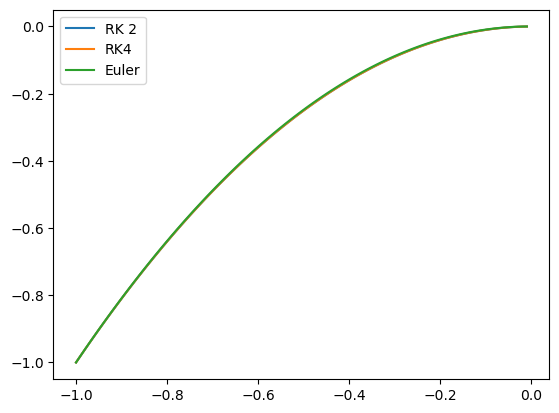

In [21]:
#definicion de la funcion
def funcion_ode(_t, _x):
    return (lambda _t, _x: 2*_x/_t)

#Valores iniciles
a = -1    #inicio del lapso 
b = 0  #final del lapso
h = 0.01  #esparcimiento
x_inicial = -1 #valor inicial de de funcion ode x en el momento t0

grafica_comparativa()

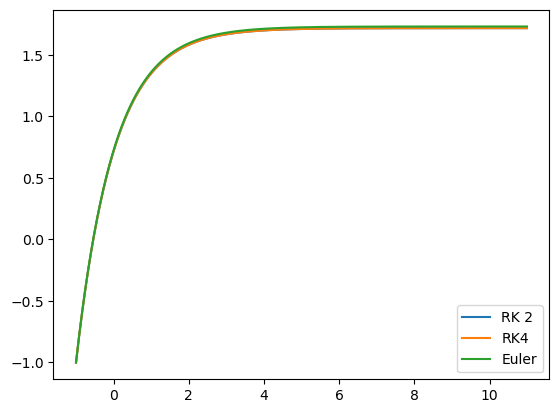

In [147]:
#definicion de la funcion
def funcion_ode(_t, _x):
    return (lambda t, s: np.exp(-t))

#Valores iniciales
a = -1    #inicio del lapso 
b = 11   #final del lapso
h = 0.01  #esparcimiento
x_inicial = -1 #valor inicial de de funcion ode x en el momento t0

grafica_comparativa()

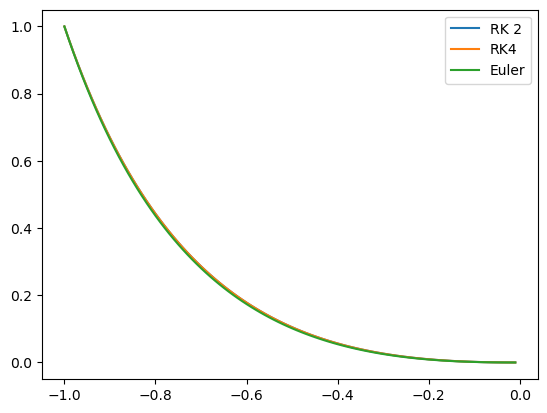

In [9]:
#definicion de la funcion
def funcion_ode(_t, _x):
    return (lambda _t, _x: 2*_x/_t + 2* np.power(_x,2)/np.power(_t, 3))

#Valores iniciales
a = -1   #inicio del lapso 
b = 0  #final del lapso
h = 0.01  #esparcimiento
x_inicial = 1 #valor inicial de de funcion ode x en el momento t0

grafica_comparativa()

## Ecuaciones Diferenciales Multivariables

Podemos tener más de una variable dependiente, e.g.,
$$
\frac{\text d x}{\text d t} = f_x(x, y, t), \quad \frac{\text d y}{\text d t} = f(x, y, t),
$$
en las cuales $f_x$ y $f_y$ son posiblemente ecuaciones no lineares, lo cual imposibilita en muchos casos el uso de métodos analíticos. 

Note que estas no son ecuaciones diferenciales parciales, dado que existe solamente una variable independiente.

La forma general de estas ecuaciones diferenciales es
$$
\frac{\text d \mathbf{r}}{\text d t} = \mathbf{f}(\mathbf{r}, t),
$$
con $\mathbf{r} = (x, y, \cdots)$ y $\mathbf{f}(\mathbf{r}, t) = (f_x(\mathbf{r}, t), f_y(\mathbf{r}, t), \cdots)$. 

**En estos casos los métodos de Euler y Runge-Kutta se pueden utilizar directamente sobre los vectores, generalizando las ecuaciones que vimos anteriormente**.

## Ecuaciones Diferenciales de Mayor Orden

La idea es reducir el orden de la ecuación diferencial a cambio de resolver **ecuaciones diferenciales simultáneas**. Por ejemplo, la ecuación
$$
\frac{\text d^2 x}{\text d t^2} = f(x, \frac{\text d x}{\text d t}, t),
$$
es equivalente a resolver de forma s
imultánea
* $\frac{\text d x}{\text d t} = y$,
* $\frac{\text d y}{\text d t} = f(x, y, t)$.

De la misma forma, para ecuaciones de $3^{\rm er}$ orden, construimos el conjunto de ecuaciones simultáneas
* $\frac{\text d x}{\text d t} = y$,
* $\frac{\text d y}{\text d t} = z$,
* $\frac{\text d z}{\text d t} = f(x, y, z, t)$.

Estas ecuaciones simultáneas se pueden resolver con el método deseado (Euler, RK2, RK4) para un sistema multivariable. 

Este procedimiento se puede realizar para ecuaciones de orden mayor, aunque las ecuaciones diferenciales de orden mayor a 3 en la ciencia son muy poco comunes.

## Métodos adaptativos

Existen métodos para modificar el paso temporal $h$ de manera tal que los pasos no se toman de forma equidistante. La idea es mantener el error aproximadamente constante a medida que se cambia el paso temporal. 

Esto puede ser útil para funciones que cambian muy rápido en el tiempo. 

Ver Newman Cap 8.4 para más detalles. Algunas bibliotecas en `Python` incluyen metodología para adaptar el algoritmo a pasos $h$ cambiantes. Estas metodologías deben ser utilizadas con cuidado dado que incurren en un costo computacional más alto.

# Simetría de inversión temporal

Muchos problemas en la física involucran una simetría importante de **invariancia de inversión temporal**, la cual puede ser entendida como una consecuencia (o resultado de) la **conservación de la energía total**.

El problema que surge con los métodos que hemos derivado es que **no respetan esta simetría de forma directa**, es decir, si empezamos con el valor final y aplicamos el método en reversa no obtenemos la condición inicial.

<div>
<img src="Fig2.png" width="550"/>
</div>

El ejemplo anterior es la solución del problema del péndulo no lineal sin fricción, con las ecuaciones
$$
\frac{\text d \theta}{\text d t} = \omega, \quad \frac{\text d \omega}{\text d t} = -\frac{g}{l}\sin \theta.
$$
Al aplicar el método RK2 con cierto valor de $h$, la solución puede diverger como se muestra en la figura. Existen métodos que respetan la simetría temporal, los cuales dan el resultado correcto como se muestra. Un ejemplo corresponde al *método de saltos intermedios*.

Cabe destacar que este problema usualmente se resuelve haciendo el valor de $h$ más pequeño.

## Método de saltos intermedios (*leapfrog methods*)

Existe una forma de utilizar los métodos anteriores respetando la simetría temporal. La forma más básica, es el método de saltos intermedios.

<div>
<img src="Fig3.png" width="550"/>
</div>

**En la figura anterior:** 
  - El diagrama (a) corresponde al caso RK2: utilizamos el punto medio para evaluar la evolución al paso completo
  - El diagrama (b) corresponde al método de saltos intermedios: utilizamos el punto medio para evaluar la evolución al paso completo, pero cada punto medio se calcula utilizando el punto medio anterior.
  
Se puede demostrar que este procedimiento respeta la simetría de inversión temporal, de manera tal que el error incurrido es de aproximación y no sistemático, como puede ocurrir con métodos directos.

## Métodos avanzados

Existen métodos más avanzados para llevar los saltos intermedios a ordenes mayores.

Para más información: Newman Cap. 8.

# Laboratorio

Resuelva la ecuación diferencial
$$
\frac{{\rm d}x}{{\rm d}t} = -x^3 + \sin(t),
$$
con la condición inicial $x(0) = 0$ desde $t = 0$ hasta $t = 10$.

* Utilice los métodos: Euler, RK2 y RK4.
* Grafique la solución para cada caso con 20 pasos y 1000 pasos en el mismo gráfico (es decir, tres gráficos con dos curvas cada uno)